In [ ]:
# !pip install -r requirements.txt

### Dataset Download

In [ ]:
!pip install gdown==4.6.0

In [ ]:
!gdown 1p-rDwR--uHZb-_YKvynDKGBcKQJdYY-d

In [ ]:
!unzip lol_dataset.zip

### Library Imports

In [1]:
import os
from torch.utils.data import Dataset,DataLoader
import torch
from PIL import Image
import torchvision.transforms as T
import numpy as np
import torch.nn as nn
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt

### Configurations

In [2]:
batch_size = 4
patch_size = 128
base_feature_maps = 32
n_epochs = 100
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Dataset Visualisation

In [3]:
root_path  = os.getcwd()
root_path

'/mnt/c/Users/Hrishikesh/Desktop/hrishi/WORK/SRM/SRM-IEEE-SPS-Winter-School/Day3'

In [ ]:
os.rename(os.path.join(root_path,'lol_dataset/our485'),os.path.join(root_path,'lol_dataset/train'))
os.rename(os.path.join(root_path,'lol_dataset/eval15'),os.path.join(root_path,'lol_dataset/val'))

In [ ]:
rgb_dir = os.path.join(root_path,'lol_dataset/train')
high_files = os.listdir(os.path.join(rgb_dir, 'high'))
low_files = os.listdir(os.path.join(rgb_dir, 'low'))
high_files = [os.path.join(rgb_dir, 'high', file_name)for file_name in high_files if file_name.endswith('.png')]
low_files = [os.path.join(rgb_dir, 'low', file_name)for file_name in low_files if file_name.endswith('.png')]

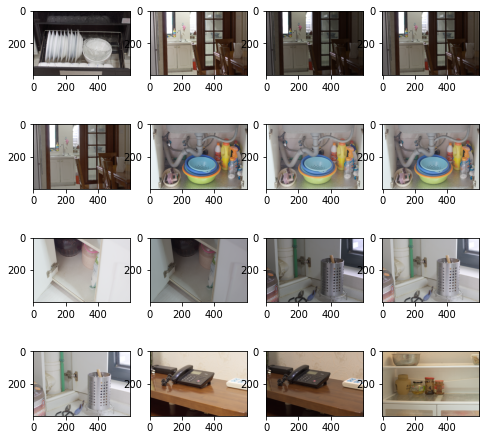

In [5]:
fig = plt.figure(figsize=(8,8))
columns = 4
rows = 4
for i in range(1, columns*rows +1):
    img = cv2.cvtColor(cv2.imread(high_files[i]),cv2.COLOR_BGR2RGB)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

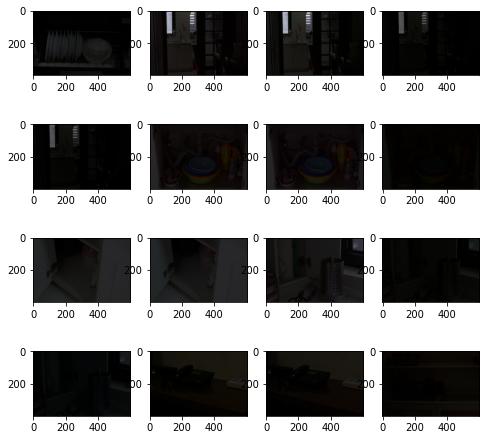

In [6]:
fig = plt.figure(figsize=(8,8))
columns = 4
rows = 4
for i in range(1, columns*rows +1):
    img = cv2.cvtColor(cv2.imread(low_files[i]),cv2.COLOR_BGR2RGB)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

### Custom Dataset Pipeline 

In [7]:
class LolDataLoader(Dataset):
    def __init__(self, rgb_dir, transform=None):
        super(LolDataLoader, self).__init__()

        self.transform = transform

        high_files = sorted(os.listdir(os.path.join(rgb_dir, 'high')))
        low_files = sorted(os.listdir(os.path.join(rgb_dir, 'low')))
        
        self.high_filenames = [os.path.join(rgb_dir, 'high', x) for x in high_files if self.is_png_file(x)]
        self.low_filenames = [os.path.join(rgb_dir, 'low', x)  for x in low_files if self.is_png_file(x)]

        self.tar_size = len(self.high_filenames)  # get the size of target

    def __len__(self):
        return self.tar_size
    def is_png_file(self,filename):
        return any(filename.endswith(extension) for extension in [".png"])

    def __getitem__(self, index):
        high = Image.open(self.high_filenames[index])
        low = Image.open(self.low_filenames[index])

        high = np.asarray(high)
        low = np.asarray(low)


        high_filename = os.path.split(self.high_filenames[index])[-1]
        low_filename = os.path.split(self.low_filenames[index])[-1]
        comb_im = np.concatenate([high,low],axis=-1)
        if self.transform is not None:
            comb_im = self.transform(comb_im)
        comb_im = torch.split(comb_im,split_size_or_sections = 3,dim = 0)
        high, low = comb_im[0],comb_im[1]
        return high, low, high_filename, low_filename

### Transformation/Augmentations to be applied on Trainig and Validation Data 

In [9]:
train_transforms = T.Compose([T.RandomCrop((patch_size,patch_size)),T.ToTensor()])
val_transforms = T.Compose([T.ToTensor()])

### Dataset Loader for Trainig and Validation

In [10]:
train_transforms = T.Compose([T.ToTensor(),T.RandomCrop((128,128))])
val_transforms = T.Compose([T.ToTensor()])
train_dataset = LolDataLoader(rgb_dir=os.path.join(root_path,'lol_dataset/train'),transform=train_transforms)
val_dataset = LolDataLoader(rgb_dir=os.path.join(root_path,'lol_dataset/val'),transform=val_transforms)
train_data_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
val_data_loader = DataLoader(val_dataset,batch_size=batch_size,shuffle=False)

In [ ]:
# for count,(inp,gt,i_name,g_name) in enumerate(val_data_loader):
#     inp_images = [(inp[i,...].permute(1,2,0)*255).cpu().numpy() for i in range(inp.shape[0])]
#     gt_images = [(gt[i,...].permute(1,2,0)*255).cpu().numpy() for i in range(gt.shape[0])]
#     inps = np.concatenate(inp_images,axis=1)
#     gts = np.concatenate(gt_images,axis=1)
#     final = np.concatenate([inps,gts],axis=0)
#     cv2.imwrite(f'{count}.jpg',cv2.cvtColor(final,cv2.COLOR_RGB2BGR))


### Model Development using Sequential Module of Pytorch

In [11]:
from unet import UNet

In [12]:
Relight = UNet(n_channels=3)
Relight = Relight.to(device)

### Sequential Models

> ENCODER

In [ ]:
Encoder = nn.Sequential(nn.Conv2d(in_channels=3,out_channels=base_feature_maps,kernel_size = 3,padding='same'),nn.ReLU(),
        nn.Conv2d(in_channels=base_feature_maps,out_channels=base_feature_maps,kernel_size = 3,padding='same'),nn.ReLU(),nn.MaxPool2d(kernel_size=2),
        nn.Conv2d(in_channels=base_feature_maps,out_channels=base_feature_maps*2,kernel_size = 3,padding='same'),nn.ReLU(),
        nn.Conv2d(in_channels=base_feature_maps*2,out_channels=base_feature_maps*2,kernel_size = 3,padding='same'),nn.ReLU(),nn.MaxPool2d(kernel_size=2),
        nn.Conv2d(in_channels=base_feature_maps*2,out_channels=base_feature_maps*4,kernel_size = 3,padding='same'),nn.ReLU(),
        nn.Conv2d(in_channels=base_feature_maps*4,out_channels=base_feature_maps*4,kernel_size = 3,padding='same'),nn.ReLU(),nn.MaxPool2d(kernel_size=2))


> DECODER

In [ ]:
Decoder = nn.Sequential(nn.Conv2d(in_channels=base_feature_maps*4,out_channels=base_feature_maps*4,kernel_size = 3,padding='same'),nn.ReLU(),
        nn.Conv2d(in_channels=base_feature_maps*4,out_channels=base_feature_maps*4,kernel_size = 3,padding='same'),nn.ReLU(),
        nn.ConvTranspose2d(in_channels=base_feature_maps*4,out_channels=base_feature_maps*2,kernel_size=2,stride=2),
        nn.Conv2d(in_channels=base_feature_maps*2,out_channels=base_feature_maps*2,kernel_size = 3,padding='same'),nn.ReLU(),
        nn.Conv2d(in_channels=base_feature_maps*2,out_channels=base_feature_maps*2,kernel_size = 3,padding='same'),nn.ReLU(),
        nn.ConvTranspose2d(in_channels=base_feature_maps*2,out_channels=base_feature_maps,kernel_size=2,stride=2),
        nn.Conv2d(in_channels=base_feature_maps,out_channels=base_feature_maps,kernel_size = 3,padding='same'),nn.ReLU(),
        nn.Conv2d(in_channels=base_feature_maps,out_channels=base_feature_maps,kernel_size = 3,padding='same'),nn.ReLU(),
        nn.ConvTranspose2d(in_channels=base_feature_maps,out_channels=base_feature_maps,kernel_size=2,stride=2),
        nn.Conv2d(in_channels=base_feature_maps,out_channels=3,kernel_size = 3,padding='same'))

> Relight Model

In [ ]:
Relight = nn.Sequential(Encoder,Decoder)
Relight = Relight.to(device)

### Loss and Optimizer Intialisation

In [ ]:
criterion  = nn.L1Loss()
optimizer = torch.optim.Adam(Relight.parameters(),lr =1e-4)

### Metrics

![](assets/PSNR.jpeg)

In [ ]:
def PSNR(tar_img, prd_img):
    mse = torch.mean((torch.clamp(tar_img,0,1) - torch.clamp(prd_img,0,1)) ** 2)
    ps = 20 * torch.log10(1.0 / torch.sqrt(mse))
    return ps

###  Model Training and Validation

In [ ]:
def train():
    running_train_loss = 0.0
    running_psnr  = 0.0
    Relight.train()
    for high,low,_,_ in tqdm(train_data_loader):
        high = high.to(device)
        low = low.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        with torch.set_grad_enabled(True):
            outputs = Relight(low)
            loss = criterion(outputs,high)
            loss.backward()
            optimizer.step()
        running_psnr += PSNR(high,outputs)
        running_train_loss += loss.item()
    epoch_loss = running_train_loss / (len(train_data_loader))
    epoch_psnr = running_psnr / (len(train_data_loader))
    return epoch_loss,epoch_psnr


In [ ]:
def validation():
    running_val_loss = 0.0
    running_psnr  = 0.0
    Relight.eval()
    for high,low,_,_ in tqdm(val_data_loader):
        high = high.to(device)
        low = low.to(device)
        with torch.set_grad_enabled(False):
            outputs = Relight(low)
            loss = criterion(outputs,high)
        running_val_loss += loss.item()
        running_psnr += PSNR(high,outputs)
    epoch_loss = running_val_loss / (len(val_data_loader))
    epoch_psnr = running_psnr / (len(val_data_loader))
    return epoch_loss,epoch_psnr

In [ ]:
for epoch in range(n_epochs):
    train_loss,train_psnr = train()
    val_loss,val_psnr = validation()
    print(f'Epoch number = {epoch+1} l1 train loss = {train_loss},train psnr = {train_psnr}')
    print(f'Epoch number = {epoch+1} l1 val loss = {val_loss}, val psnr = {val_psnr}')

### Model Saving and Loading

In [ ]:
torch.save(Relight.state_dict(),'relight.pt')

In [13]:
Relight.load_state_dict(torch.load('relight.pt'))

<All keys matched successfully>

###  Model Testing

In [14]:
Relight.eval()
high,low,_,_ = iter(val_data_loader)
high = high[0].to(device)
low = low[0].to(device)
with torch.set_grad_enabled(False):
    outputs = Relight(low)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


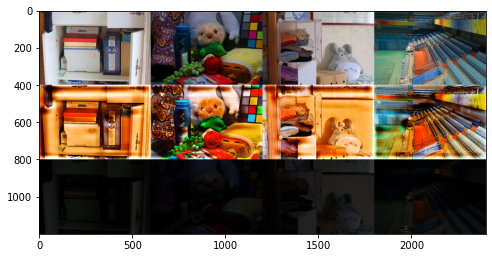

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


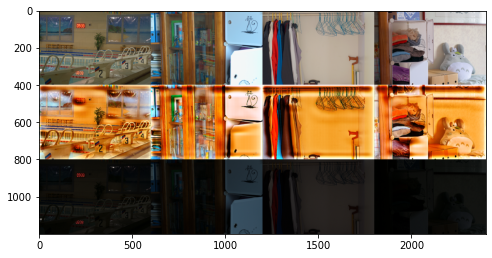

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


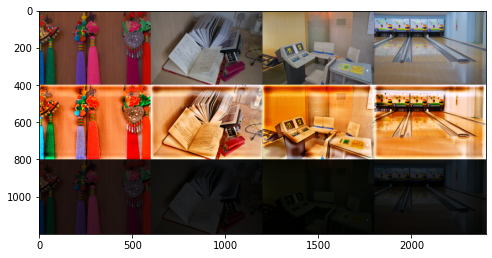

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


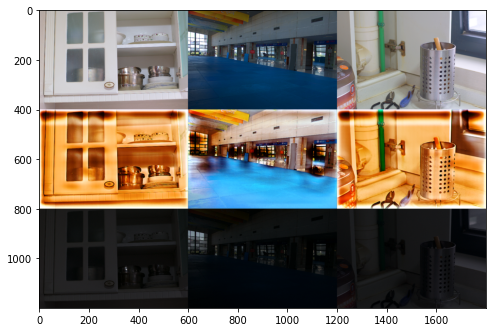

In [19]:
Relight.eval()
for count,(low,high,_,_) in enumerate(val_data_loader):
    high = high.to(device)
    low = low.to(device)
    with torch.set_grad_enabled(False):
        outputs = Relight(low)
    inp_images = [(low[i,...].permute(1,2,0)).cpu().numpy() for i in range(low.shape[0])]
    gt_images = [(high[i,...].permute(1,2,0)).cpu().numpy() for i in range(high.shape[0])]
    pred_images = [(outputs[i,...].permute(1,2,0)).cpu().numpy() for i in range(outputs.shape[0])]
    inps = np.concatenate(inp_images,axis=1)
    gts = np.concatenate(gt_images,axis=1)
    preds = np.concatenate(pred_images,axis=1)
    final = np.concatenate([inps,preds,gts],axis=0)
    fig = plt.figure(figsize=(8,8))
    plt.imshow(final)
    plt.show()